# Import dataset
Every row in X is a unrolled 20 x 20 image of written digits (0-9). Every value in Y is the digit to the corresponding image.

In [145]:
import scipy.io as sio
import numpy as np

mnist = sio.loadmat("./ex4data1.mat")
X,y = mnist.get("X"), mnist.get("y")

image_size = int(np.sqrt(X.shape[1]))
input_size = (image_size ** 2) + 1

X.shape, y.shape, image_size

((5000, 400), (5000, 1), 20)

# Preprocess dataset

In [147]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3750, 400), (1250, 400), (3750, 1), (1250, 1))

# Plot 100 images
Randomly choosing 100 images from the training set and plotting them in a figure.

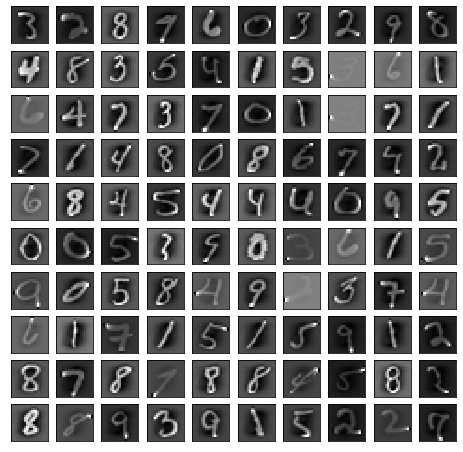

In [148]:
import matplotlib.pyplot as plt

random_indices = np.random.choice(np.arange(X_train.shape[0]), 100)

plt.figure(figsize=(8,8))
for index, (image, label) in enumerate(zip(X_train[random_indices], y_train[random_indices])):
    plt.subplot(10, 10, index + 1)
    plt.imshow(image.reshape(image_size,image_size).T, cmap=plt.cm.gray)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))

# Prepare X
Each row of X is 400 deminsional vector representing a 20 x 20 grayscale image. So that the number of the neurons for the first layer should be 401 (one bias and 400 activation neurons). Therefore, we need to insert a first column to be the bias neuron of each image. 

In [149]:
def perpare_X(X_):
    X_ = np.insert(X_, 0, values=np.ones(X_.shape[0]), axis=1)
    return X_

X_train = perpare_X(X_train)
X_test = perpare_X(X_test)

X_train.shape, X_test.shape

((3750, 401), (1250, 401))

# Prepare y
Selecting all value 10 in y and replace by 0. Our neural network should have 10 outputs matching with 10 digits. So that we need to replace the value in each row to be a vector of 10 dimensional and the value denotes which postion in that column should be 1. For example, 3 -> [0,0,0,1,0,0,0,0,0,0,0]. We can use **OneHotEncoder** function from sklearn to automatically perform this transformation. Then performing a transpose to make each column become an output.

In [150]:
from sklearn.preprocessing import OneHotEncoder
def perpare_y(y_):
    oe = OneHotEncoder()
    y_ = oe.fit_transform(y_).toarray()
    return y_

y_train = perpare_y(y_train) # y_test doesnt need to encode
y_train.shape, y_test.shape

((3750, 10), (1250, 1))

# Utilitiy functions

In [151]:
from scipy.special import expit

def serialize(a, b):
    return np.concatenate((np.ravel(a), np.ravel(b)))

def deserialize(seq):
    return seq[:25 * input_size].reshape(25,input_size), seq[25*input_size:].reshape(10,26)

def sigmoid (X): 
    return expit(X)

# Forward propagation
## Network structure
|                       | Input Layer | Layer 2 | Output Layer |
| --------------------- | ----------- | ------- | ------------ |
| No. of active neurons | 400         | 25      | 10           |
| No. of bias           | 1           | 1       | 0            |

theta_1: (25, 401) -- 25 neurons in next layer x 400 weights + 1 bias

theta_2: (10, 26) -- 10 neurons in next layer x 25 weights + 1 bias

## Bias
As a2 is the only one hidden layer in our case, we need to add the bias term for this layer.

In [152]:
def forward_propagate(theta_seq, X):
    m = X.shape[0]
    theta_1, theta_2 = deserialize(theta_seq)
    
    a1 = X
    z2 = a1 @ theta_1.T
    a2 = np.insert(sigmoid(z2), 0, values=np.ones(m), axis=1)
    z3 = a2 @ theta_2.T
    h = sigmoid(z3)
    
    return a1, z2, a2, z3, h

# Test thetas
A good set of theta_1 and theta_2. This set suits the dataset which its output represents 10 as digit 0 the best.

In [153]:
thetas = sio.loadmat("./ex4weights.mat")
theta_1 = thetas['Theta1']
theta_2 = thetas['Theta2']
theta_1.shape, theta_2.shape

((25, 401), (10, 26))

# Cost function
theta: (n+1,) -- n+1 parameters(weights) matched with n+1 features

X: (5000, 401) -- m samples x (n+1) features

y: (5000, 10)

$$
h_{\Theta}(x) \in \mathbb{R}^{K} \quad\left(h_{\Theta}(x)\right)_{i}=i^{t h} \text { output }
$$

$$
\begin{aligned}
J(\Theta)=&-\frac{1}{m}\left[\sum_{i=1}^{m} \sum_{k=1}^{K} y_{k}^{(i)} \log \left(h_{\Theta}\left(x^{(i)}\right)\right)_{k}+\left(1-y_{k}^{(i)}\right) \log \left(1-\left(h_{\Theta}\left(x^{(i)}\right)\right)_{k}\right)\right] \\
&+\frac{\lambda}{2 m} \sum_{l=1}^{L-1} \sum_{i=1}^{s_{l}} \sum_{j=1}^{s_{l+1}}\left(\Theta_{j i}^{(l)}\right)^{2}
\end{aligned}
$$

In [154]:
def regularized_j(theta_seq, X, y, l =1):
    m = X.shape[0] # training sample size
    theta_1, theta_2 = deserialize(theta_seq)
    a1, z2, a2, z3, h = forward_propagate(theta_seq,X)
    
    # Cost term
    j = (np.multiply(-y, np.log(h)) - np.multiply((1 - y), np.log(1 - h))).sum() / m
    
    # Regularization term
    reg_1 = (l / (2*m)) * np.power(theta_1[:, 1:], 2).sum()
    reg_2 = (l / (2*m)) * np.power(theta_2[:, 1:], 2).sum()
    
    return j + reg_1 + reg_2

In [155]:
regularized_j(serialize(theta_1, theta_2), X_train, y_train, 1) # test the j function

12.541970332295978

# Backward propagation
## Errors
Define the J function as (ignore the regularized term):
$$
\begin{aligned}
J(\Theta)=&-\frac{1}{m}\sum_{i=1}^{m} cost(i) \\
\end{aligned}
$$

$$
\begin{aligned}
cost(i)=\sum_{k=1}^{K} y_{k}^{(i)} \log \left(h_{\Theta}\left(x^{(i)}\right)\right)_{k}+\left(1-y_{k}^{(i)}\right) \log \left(1-\left(h_{\Theta}\left(x^{(i)}\right)\right)_{k}\right) \\
\end{aligned}
$$

Formally, the error $\delta^{(l)}_{j} = \frac{\partial}{\partial z^{(i)}_{j}} cost(i)$

### Error of each layer
Output layer error:
$$
\delta^{(L)}=a^{(L)}-y
$$
Hidden layer errors:
$$
\delta^{(l)}=\left(\Theta^{(l)}\right)^{T} \delta^{(l+1)} \cdot^{*} g^{\prime}\left(z^{(l)}\right)
$$
**Note that it performs element-wise multiplication**

No error for the input layer.
## Partial derivative
### For one sample
$$
\frac{\partial}{\partial \Theta_{i j}^{(l)}} J(\Theta)=a_{j}^{(l)} \delta_{i}^{l+l}
$$

### For all samples
Sample size: $m$

No. of units (not counting bias unit) in layer $l$: $s_l$

Penalize coefficient: $\lambda$

$$
\begin{array}{ll}
\triangle_{i j}^{(l)} = \sum_{i}^{m} \sum_{j}^{s_l} a_{j}^{(l)} \delta_{i}^{l+l} \\
{D_{i j}^{(l)}=\frac{1}{m} \triangle_{i j}^{(l)}+\lambda \Theta_{i j}^{(l)}} & {\text { if } j \neq 0} \\
{D_{i j}^{(l)}=\frac{1}{m} \triangle_{i j}^{(l)}} & {\text { if } j=0}
\end{array}
$$

## Update $\Theta$
This process is automatically performed for serveral iterations by the minimize function. The theory behind is $\Theta^{l} =  \Theta^{l} - \alpha D^{l} $
where $\alpha$ is some positive real number denotes as the learning rate.

In [156]:
def sigmoid_gradient (X): 
    return np.multiply(sigmoid(X), 1-sigmoid(X))

In [157]:
def j_gradient(theta_seq, X, y, l =1):
    m = X.shape[0]
    theta_1, theta_2 = deserialize(theta_seq)
    delta_1, delta_2 = np.zeros(theta_1.shape), np.zeros(theta_2.shape) # (25,401), (10,26)
    a1, z2, a2, z3, h = forward_propagate(theta_seq,X)
    
    # cost term gradient
    for i in range(m):
        h_i = h[i, :] # predict output of the i_th sample (10,)
        y_i = y[i, :] # actual output of the i_th sample (10,)
        d3_i = h_i - y_i # (10,)
        
        a2_i = a2[i, :] # (25,)
        z2_i = np.insert(z2[i, :], 0, np.ones(1)) # add the bias -> (26,) not actually used, just to match the shape to perform @
        d2_i = np.multiply(theta_2.T @ d3_i, sigmoid_gradient(z2_i)) #(26,)
                           
        a1_i = a1[i, :] #(401,) no error for the input level
        
        delta_1 += np.matrix(d2_i[1:]).T @ np.matrix(a1_i) # (1,25).T * (1,401), exclude the bias
        delta_2 += np.matrix(d3_i).T @ np.matrix(a2_i) # (1,10).T * (1,26)
        
    delta_1 /= m
    delta_2 /= m
    
    # regularized term
    theta_1[:,0] = 0 # dont penalize bias
    theta_2[:,0] = 0 # dont penalize bias
    
    delta_1 += (l / m) * theta_1
    delta_2 += (l / m) * theta_2
    
    return serialize(delta_1, delta_2)

# Apply to minimize function
if jac = True, then the func should return both the cost and gradient. Otherwise jac and func should take the same parameters: (x, args*)

In [158]:
import scipy.optimize as opt
eps = 0.12
init_theta = np.random.uniform(-eps, eps, 25*input_size + 10*26)
res = opt.minimize(fun = regularized_j,
                x0 = init_theta,
                args = (X_train, y_train, 1),
                method = "TNC",
                jac = j_gradient,
                options = {'maxiter': 100})

# View results

Cost value 1.2015638441555176
              precision    recall  f1-score   support

     digit 0       0.96      0.96      0.96       119
     digit 1       0.88      0.97      0.92       125
     digit 2       0.92      0.88      0.90       120
     digit 3       0.93      0.92      0.93       118
     digit 4       0.85      0.94      0.89       114
     digit 5       0.89      0.87      0.88       138
     digit 6       0.91      0.93      0.92       115
     digit 7       0.89      0.90      0.89       129
     digit 8       0.94      0.89      0.91       140
     digit 9       0.92      0.83      0.87       132

    accuracy                           0.91      1250
   macro avg       0.91      0.91      0.91      1250
weighted avg       0.91      0.91      0.91      1250



Text(0.5, 1, 'Confusion matrix')

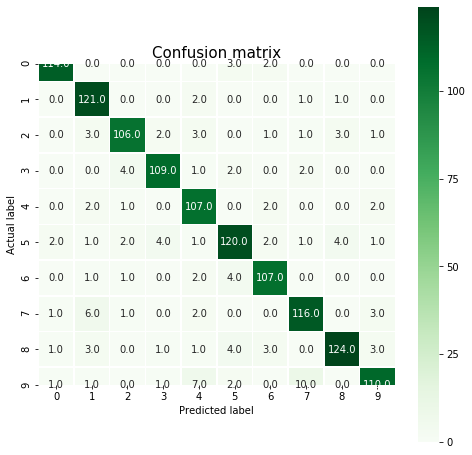

In [159]:
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn import metrics

final_theta = res.x
_,_,_,_,h = forward_propagate(final_theta, X_test)
cost = regularized_j(final_theta, X_test, perpare_y(y_test), 1)
print("Cost value", cost)

y_test_pred = np.argmax(h, axis=1)
y_test = y_test.reshape(y_test.shape[0],)
target_names = np.array(["digit {:d}".format(i) for i in range(10)])

print(classification_report(y_test, y_test_pred, target_names=target_names))

cm = metrics.confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt=".1f", linewidths=.5, square = True, cmap = 'Greens')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title("Confusion matrix", size = 15)